<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/ci_aki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of AKI risk depending on BP during surgery
In this example, we will calculate the risk of acute kidney injury (AKI) depending on blood pressure during surgery, using the VitalDB open dataset.

## Required libraries and datasets

In [1]:
!pip install vitaldb
import vitaldb
import pandas as pd
import numpy as np

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # Load clinical data
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # Load track list
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # Load lab result

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.6 MB/s eta 0:00:00


## Case Selection
- Let's use only 100 emergency surgical patients.

In [16]:
# inclusion / exclusion criteria
caseids = list(
    set(df_trks.loc[df_trks['tname'] == 'Vigileo/CI', 'caseid']) |
    set(df_trks.loc[df_trks['tname'] == 'EV1000/CI', 'caseid']) |
    set(df_trks.loc[df_trks['tname'] == 'Vigilance/CI', 'caseid'])
)
print('Total {} cases found'.format(len(caseids)))

Total 981 cases found


## Load and calculate data for each case
- First of all, calculate the preoperative and postoperative creatinine concentration for each case, and then calculate the possibility that AKI occurs.

- Secondly, obtain the ART_MBP data from vitaldb datasets. Then, calculate the proportion of surgeries that have a measured value lower than the threshold between 40-80 mmHg in all surgeries.

In [20]:
# Set blood pressure threshold
thresholds = np.arange(0, 4, 0.1)

# Save the final result
rows = []
for caseid in caseids:
    print('loading {}...'.format(caseid), flush=True, end='')

    # Column ['anend'] : anesthesia end time
    aneend = df_cases[(df_cases['caseid'] == caseid)]['aneend'].values[0]

    # Last creatinine concentration before surgery
    preop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] < 0) & (df_labs['name'] == 'cr')].sort_values(by=['dt'], axis=0, ascending=False)['result'].values.flatten()
    if len(preop_cr) == 0:
        print('no preop cr')
        continue
    preop_cr = preop_cr[0]

    # Maximum creatinine concentration within 48 hours after surgery
    postop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] > aneend) &
        (df_labs['dt'] < aneend + 48 * 3600) & (df_labs['name'] == 'cr')]['result'].max(skipna=True)
    if not postop_cr or np.isnan(postop_cr):
        print('no postop cr')
        continue

    # KDIGO stage I
    aki = postop_cr > preop_cr * 1.5

    # Blood pressure during surgery
    cis = vitaldb.load_case(caseid, '/CI').flatten()
    cis = cis[~np.isnan(cis)]
    cis = cis[(cis > 0.1) & (cis < 4)]
    if len(cis) < 10:
        print('no ci')
        continue

    # Calculate the percentage that stays for the time as increasing the blood pressure by 1 unit.
    row = {'aki':aki}
    for threshold in thresholds:
        row[f'under{threshold}'] = np.nanmean(cis < threshold) * 100

    # Append the result into row
    rows.append(row)

    print(f'{preop_cr} -> {postop_cr}, {"AKI" if aki else "no AKI"}, min CI={min(cis)}, max CI={max(cis)}')

df = pd.DataFrame(rows)
print(f'{df["aki"].sum()} AKI/ {len(df)} cases {df["aki"].mean() * 100:.1f}%')

loading 4098...0.84 -> 1.14, no AKI, min CI=0.10000000149011612, max CI=3.9000000953674316
loading 6147...no preop cr
loading 2057...1.23 -> 1.35, no AKI, min CI=1.2999999523162842, max CI=3.200000047683716
loading 12...0.58 -> 0.65, no AKI, min CI=3.299999952316284, max CI=3.9000000953674316
loading 6160...no postop cr
loading 17...1.05 -> 1.09, no AKI, min CI=2.0999999046325684, max CI=3.9000000953674316
loading 4112...no postop cr
loading 19...1.19 -> 0.78, no AKI, min CI=0.10000000149011612, max CI=3.9000000953674316
loading 6163...0.77 -> 0.76, no AKI, min CI=0.4000000059604645, max CI=3.9000000953674316
loading 22...no preop cr
loading 4120...1.03 -> 0.96, no AKI, min CI=2.9000000953674316, max CI=3.9000000953674316
loading 2072...no postop cr
loading 26...0.73 -> 0.78, no AKI, min CI=1.5, max CI=3.5999999046325684
loading 25...no preop cr
loading 29...0.78 -> 0.74, no AKI, min CI=1.0, max CI=3.0999999046325684
loading 2082...1.46 -> 1.29, no AKI, min CI=2.0999999046325684, max C

## Calculate the odds ratio for AKI prediction depending on blood pressure threshold

- Let's calculate the odds ratio regarding how much each BP class increases the risk of AKI, using the above-measured values.

In [21]:
print(thresholds)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9]


In [26]:
import statsmodels.api as sm

# Get odd ration using univariate logistic regression
df['intercept'] = 1
df['aki'] = df['aki'].astype(bool)
odd_ratios = []
for threshold in thresholds:
    c = f'under{threshold}'
    try:
        model = sm.Logit(df['aki'], df[['intercept', c]])
        res = model.fit()
    except:
        odd_ratios.append(np.nan)
        continue
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print(f'{c}\tb={b:.3f}, exp(b)={np.exp(b):.3f}, pval={pval:.3f}')

Optimization terminated successfully.
         Current function value: 0.178346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.175587
         Iterations 7
under0.2	b=0.248, exp(b)=1.281, pval=0.018
Optimization terminated successfully.
         Current function value: 0.174874
         Iterations 7
under0.30000000000000004	b=0.149, exp(b)=1.161, pval=0.036
Optimization terminated successfully.
         Current function value: 0.174802
         Iterations 7
under0.4	b=0.135, exp(b)=1.144, pval=0.030
Optimization terminated successfully.
         Current function value: 0.174555
         Iterations 7
under0.5	b=0.129, exp(b)=1.137, pval=0.026
Optimization terminated successfully.
         Current function value: 0.174458
         Iterations 7
under0.6000000000000001	b=0.123, exp(b)=1.131, pval=0.022
Optimization terminated successfully.
  

## Draw a graph
- We can find out that the odds ratio of AKI increases as the time that MBP stays below 60-65mmHg increases.


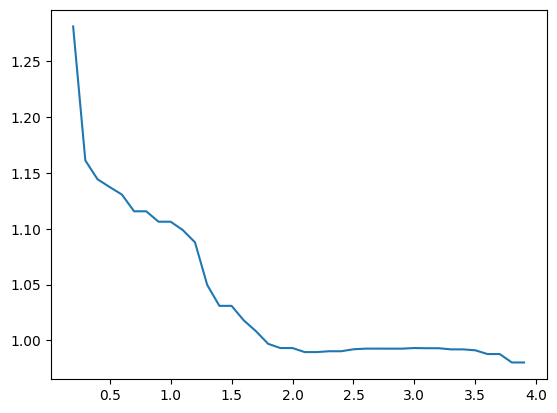

In [27]:
import matplotlib.pyplot as plt
plt.plot(thresholds, odd_ratios)
plt.show()